# Final Project EE 575

In [1]:
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import heapq
import pandas as pd

# Generate Spectrograms
Linear detrending, and a very large fft window size has been used to optimize for Signal to Noise.

In [2]:
def invert_doppler(F):
  return 3e8 * F / (10.525e9 * 2)

def get_spectrogram(wav, fs, normalized=False, velocity=False):
  ''' Extract Spectrogram (magnitudes) with times and frequencies
  wav: signal
  fs: sampling frequency
  normalized: Make magnitude range from [0-1]
  '''
  func, t, Sxx = scipy.signal.spectrogram(wav, fs, nperseg=2048, noverlap=1024, nfft=2**15, detrend='linear')
  Sxx = 10 * np.log10(Sxx)
  Sxx = Sxx[:400, :]
  func = func[:400]
  if velocity:
    func = invert_doppler(func)
  if normalized:
    min_magnitude = np.min(Sxx)
    max_magnitude = np.max(Sxx)
    Sxx = (Sxx - min_magnitude) / (max_magnitude - min_magnitude)
  return func, t, Sxx

def plot_spectrogram(wav, fs, title, velocity=False):
  ''' Plot the spectrogram from the wav file, 
  linear detrending and large fft window size to maximize SNR.
  wav: signal
  fs: sampling frequency
  title: plot title
  '''
  func, t, Sxx = get_spectrogram(wav, fs, velocity=velocity)
  plt.figure()
  plt.pcolormesh(t, func, Sxx)
  cbar = plt.colorbar()
  plt.title(f'{title}')
  cbar.set_label('Magnitude (dB)')
  if velocity:
    plt.ylabel('Velocity (m/s)')
  else:
    plt.ylabel('Doppler Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.show()

  return plt

def extract_run(run_number):
  '''Extracts the data and sampling frequency for a specific run
  run_number: 1-13 are valid
  '''
  wav_directory = "doppler_data_day2"
  wav_name = f'Day_2-Test_Trial_{run_number}.wav'
  wav_file = os.path.join(wav_directory, wav_name)
  try:
    print(f"Processing {wav_file}")
    fs, data = scipy.io.wavfile.read(wav_file)
    return fs, data
  except Exception as e:
    print(f"{wav_file} not found/read: {e}")
    return None, None


Processing doppler_data_day2\Day_2-Test_Trial_1.wav


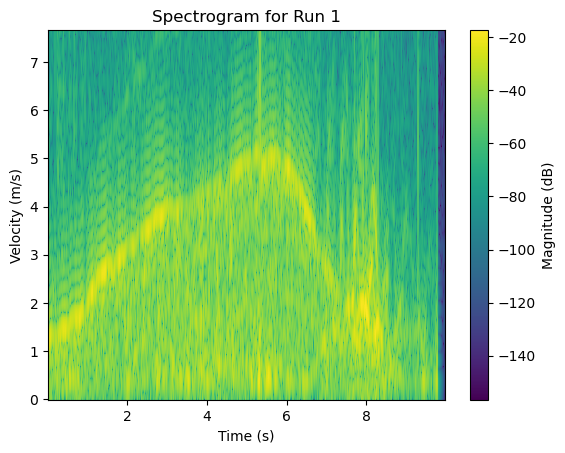

Processing doppler_data_day2\Day_2-Test_Trial_2.wav


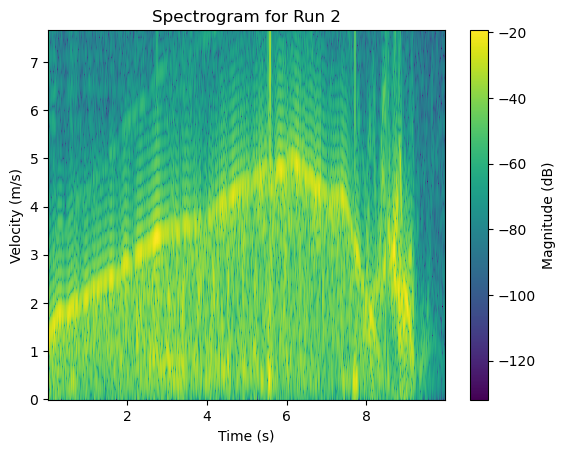

Processing doppler_data_day2\Day_2-Test_Trial_3.wav


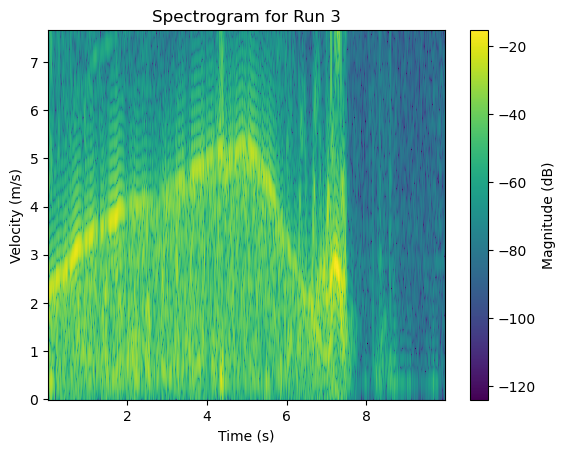

Processing doppler_data_day2\Day_2-Test_Trial_4.wav


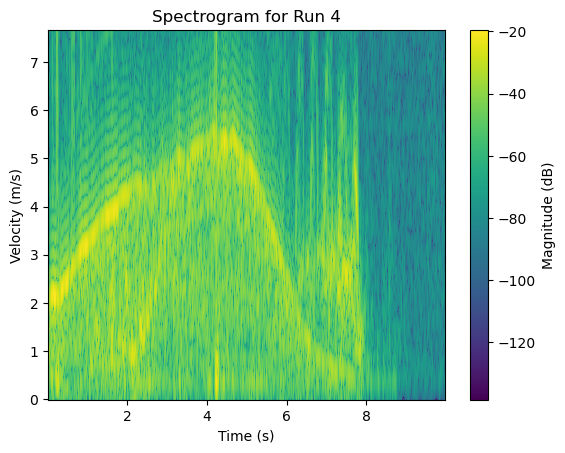

Processing doppler_data_day2\Day_2-Test_Trial_5.wav


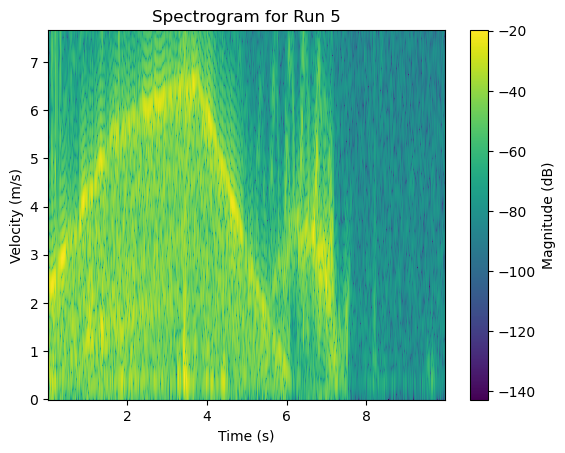

Processing doppler_data_day2\Day_2-Test_Trial_6.wav


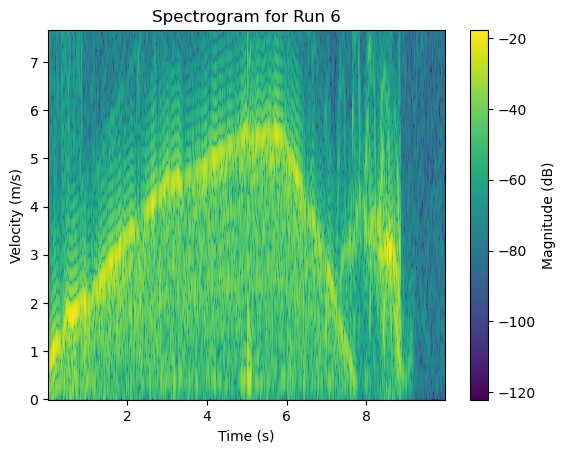

Processing doppler_data_day2\Day_2-Test_Trial_7.wav


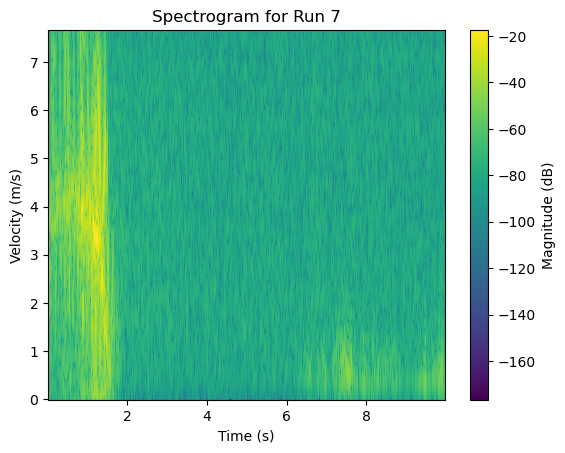

Processing doppler_data_day2\Day_2-Test_Trial_8.wav


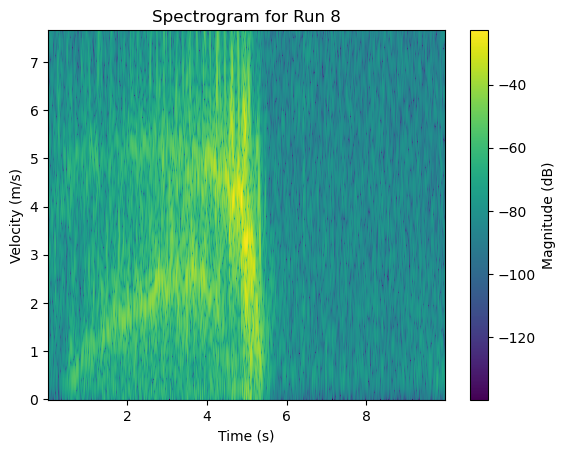

Processing doppler_data_day2\Day_2-Test_Trial_9.wav


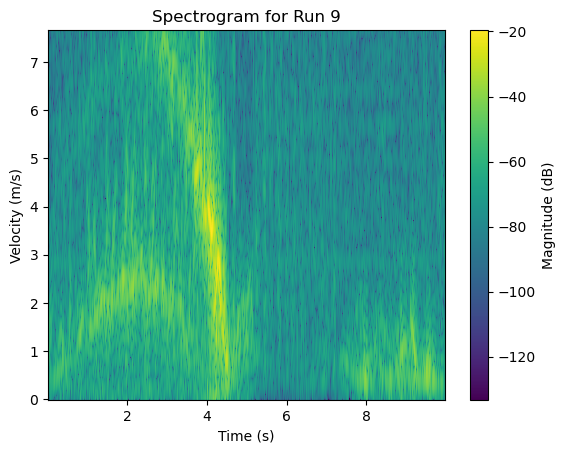

Processing doppler_data_day2\Day_2-Test_Trial_10.wav


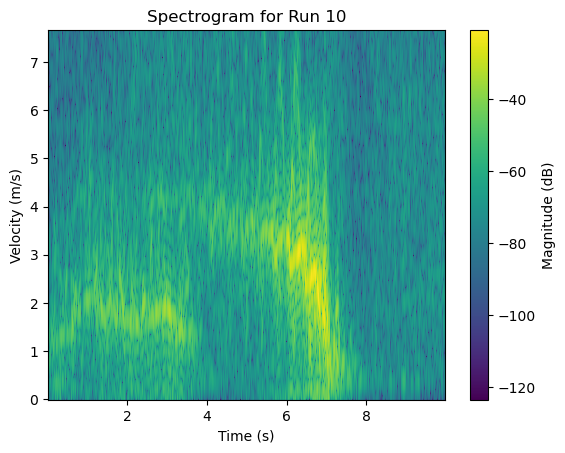

Processing doppler_data_day2\Day_2-Test_Trial_11.wav


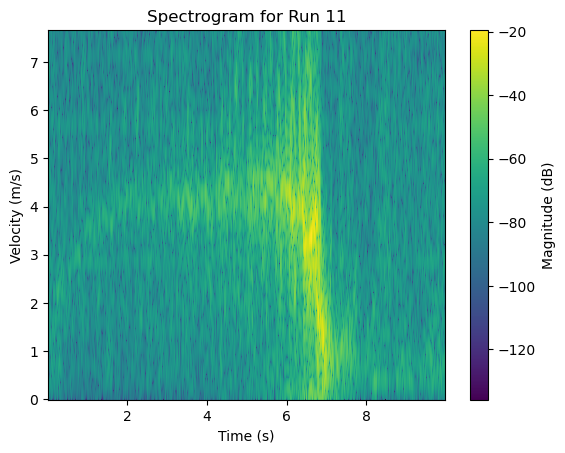

Processing doppler_data_day2\Day_2-Test_Trial_12.wav


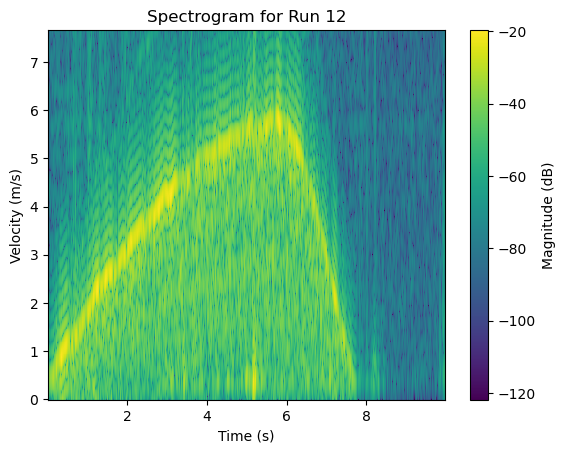

Processing doppler_data_day2\Day_2-Test_Trial_13.wav


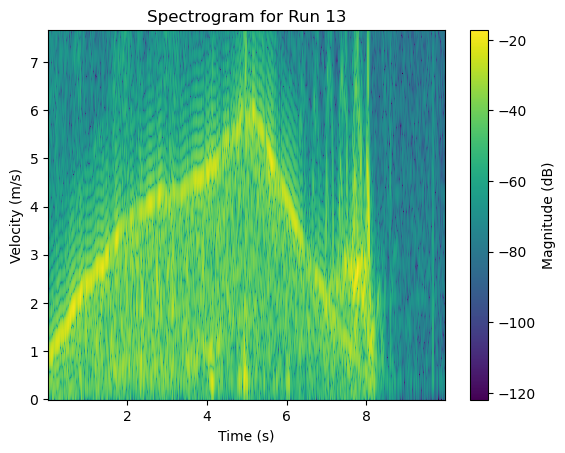

In [3]:
for run in range(1, 14): # 14):
    fs, data = extract_run(run)
    plot_spectrogram(data, fs, title=f'Spectrogram for Run {run}', velocity=True) # plot the spectrogram

# Extract Video Groundtruths

In [4]:
# Load and clean data
df = pd.read_csv('video_data.csv')
df_start = df[df['Line Distance (m)'] == 'Start']
df_clean = df[df['Line Distance (m)'] != 'Start'].copy()
df_clean['Line Distance (m)'] = pd.to_numeric(df_clean['Line Distance (m)'], errors='coerce')

# Compute average velocities
time_columns = [col for col in df.columns if 'Time' in col]
for col in time_columns:
    time_diff = pd.to_numeric(df_clean[col].shift(-1), errors='coerce') - pd.to_numeric(df_clean[col], errors='coerce')
    v_col = col.replace('Time', 'avg v')
    df_clean[v_col] = 4 / time_diff

def upsample_step(times, values, new_times):
    """
    Replicates step values (zero-order hold) over finer-grained time points.
    Assumes times are increasing.
    """
    indices = np.searchsorted(times, new_times, side='right') - 1
    indices = np.clip(indices, 0, len(values) - 1)  # prevent out-of-bounds
    return values.iloc[indices].values


def plot_spectrogram_vid_vel(run_number):
    """
    Plots the spectrogram with relative velocity between person and bike.
    run_number: int, [1,13]
    """
    fs, data = extract_run(run_number)
    func, t, Sxx = get_spectrogram(data, fs, velocity=True)

    run = f'Run{run_number}'
    plt.figure()

    interp_times = np.arange(0, max(t), 0.1)
    upsampled = {}

    for mode in ['Bike', 'Person']:
        time_col = f'{run} - {mode} Time'
        v_col = f'{run} - {mode} avg v'

        if time_col in df.columns:
            start_time = pd.to_numeric(df_start[time_col].values[0], errors='coerce')
            times = pd.to_numeric(df_clean[time_col], errors='coerce') - start_time
            velocities = df_clean[v_col].fillna(0)

            # Create step function interpolation (pad with last value)
            step_interp = upsample_step(times, velocities, interp_times)
            upsampled[mode] = step_interp

            # Set line style
            linestyle = '--' if mode == 'Person' else '-'

            # Plot original step velocity
            plt.step(times, velocities, label=f'{mode} Velocity', where='post', linestyle=linestyle)

    # Compute and plot relative velocity as a step function
    if 'Bike' in upsampled and 'Person' in upsampled:
        relative_velocity = np.abs(upsampled['Person'] - upsampled['Bike'])
        plt.step(interp_times, relative_velocity, color='red', linestyle='-', where='post', label='|Person - Bike|')

    # Plot spectrogram
    plt.pcolormesh(t, func, Sxx)
    cbar = plt.colorbar()
    cbar.set_label('Magnitude (dB)')

    plt.title(f'{run} – Relative Velocity Overlaid on Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.xlim(left=0)
    plt.legend()
    plt.grid(True)
    plt.show()


Processing doppler_data_day2\Day_2-Test_Trial_5.wav


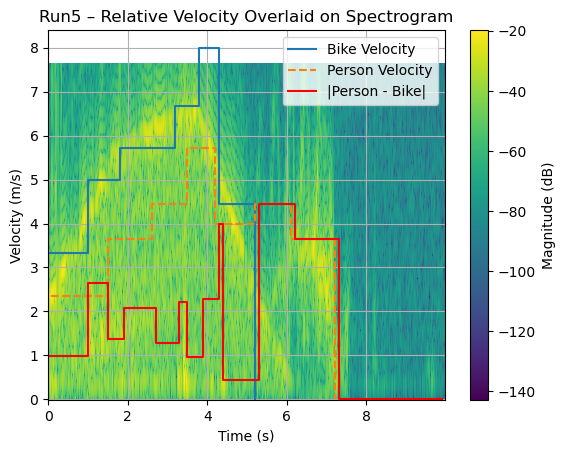

In [5]:
# Select the run number to compare with the video inferred velocities
plot_spectrogram_vid_vel(5)

# Take a look at an individual time slice

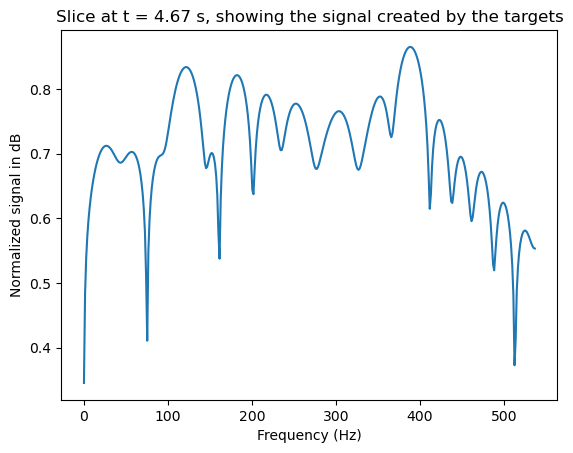

In [6]:
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)

val = 200
width = 60
slice = Sxx_norm[:,val]

plt.plot(func[:], slice)
plt.title(f'Slice at t = {t[val]:.2f} s, showing the signal created by the targets')
plt.ylabel('Normalized signal in dB')
plt.xlabel('Frequency (Hz)')
plt.show()

# Velocity Tracking Algorithm

In [22]:
class Peak:
  def __init__(self, time_idx, frequency, magnitude, penalty=False):
    self.time_idx = time_idx
    self.frequency = frequency
    self.magnitude = magnitude
    self.penalty = penalty  # If True, this peak is a penalty node (e.g., no signal)

def cost_function(path, candidate_peak, lookahead_steps, c1=1.0, c2=3, c3=0.1, boot_mag_weight=2.0, default_penalty=20, lookahead_exp=1.1):
    """
    Total cost to extend the path to candidate_peak.
    Strongly favors high-magnitude nodes at the beginning of the path.
    """
    if candidate_peak.penalty:
        if path.cost > 10:
            penalty_cost = path.cost / (path.last_peak().time_idx+0.01)
        else: penalty_cost = default_penalty
    else:
        penalty_cost = 0.0
    path = path.peaks

    N = min(len(path), 8)
    freqs = np.array([p.frequency for p in path[-N:]])
    mags = np.array([p.magnitude for p in path[-N:]])
    
    if len(path) <= 1:
        # Bootstrapping: prioritize strong magnitude early
        # Lower cost for higher magnitude
        return -boot_mag_weight * candidate_peak.magnitude + c2 * (lookahead_steps ** lookahead_exp) + penalty_cost

    # If we have enough history, compute smoothed slope
    if N >= 2:
        avg_slope = (freqs[-1] - freqs[0]) / (path[-1].time_idx - path[-N].time_idx + 1e-6)
        candidate_slope = (candidate_peak.frequency - path[-1].frequency) / (candidate_peak.time_idx - path[-1].time_idx + 1e-6)
        acceleration_cost = (candidate_slope - avg_slope) ** 2
    else:
        acceleration_cost = abs(candidate_peak.frequency - path[-1].frequency)

    # Lookahead penalty
    lookahead_penalty = lookahead_steps ** 1.1

    # Magnitude penalty (based on deviation from average magnitude)
    avg_mag = np.mean(mags) if len(mags) > 0 else 1.0
    mag_diff = abs(candidate_peak.magnitude - avg_mag)
    magnitude_penalty = mag_diff / (avg_mag + 1e-6)

    # Here I kept the lookahead penalty as a seperate parameter
    # A smarter implementation may be to have the lookahead penalty be a multiplier for the node
    # I think a lookahead_steps**1.1 multiplier may be ideal for encouraging early peak adoption
    total_cost = (
        c1 * acceleration_cost +
        c2 * lookahead_penalty +
        c3 * magnitude_penalty + penalty_cost
        )

    return total_cost - boot_mag_weight * candidate_peak.magnitude

class Path:
    def __init__(self, peaks, cost=0.0):
        self.peaks = peaks  # list of Peak objects
        self.cost = cost    # cumulative cost

    def last_peak(self):
        return self.peaks[-1]

    def time_idx(self):
        return self.last_peak().time_idx

    def extend(self, new_peak, new_cost):
        return Path(self.peaks + [new_peak], self.cost + new_cost)

# This is the beam finding function which evaluates the cost of different path options
def find_best_paths(nodes, max_lookahead=3, beam_width=5, cost_args=None):
    if cost_args is None:
        cost_args = {}

    all_paths = []

    initial_peaks = nodes[0]
    beam = [Path([p]) for p in initial_peaks]

    while beam:
        new_beam = []

        for path in beam:
            for lookahead in range(1, max_lookahead + 1):
                next_idx = path.time_idx() + lookahead
                if next_idx >= len(nodes):
                    continue
                for candidate in nodes[next_idx]:
                    cost = cost_function(path, candidate, lookahead, **cost_args)
                    new_path = path.extend(candidate, cost)
                    new_beam.append(new_path)

        if not new_beam:
            break

        beam = heapq.nsmallest(beam_width, new_beam, key=lambda p: p.cost)

    all_paths.extend(beam)
    if not new_beam:
        all_paths.append(path)

    return all_paths

In [23]:
# Loads all the potential peaks to use as candidate nodes
def get_peaks(t, Sxx_norm, max_peaks=3, threshold=0.65):
    # Find and filter peaks
    nodes = [[] for _ in range(len(t))]
    for t_idx in range(len(t)):
        spectrum_slice = Sxx_norm[:, t_idx]
        peaks, _ = scipy.signal.find_peaks(
            spectrum_slice,
            distance=5  # optional: to separate nearby peaks
        )
        if len(peaks) > 0:
            threshold_peaks = peaks[spectrum_slice[peaks] > threshold]  # Filter peaks by magnitude threshold
            sorted_peaks = sorted(threshold_peaks, key=lambda x: spectrum_slice[x], reverse=True)
            top_peaks = sorted_peaks[:max_peaks]  # Take top 3
            for peak in top_peaks:
                nodes[t_idx].append(Peak(t_idx, peak, np.exp(spectrum_slice[peak])))
        nodes[t_idx].append(Peak(t_idx, 0, 1, penalty=True))
    return nodes

# To visualize the patj found (candidate nodes are included)
def plot_spectrogram_with_path(Sxx, t, func, path, nodes, label='Tracked Path', title="Spectrogram with Tracked Path", velocity=False):
    plt.figure(figsize=(12, 6))

    # Plot the spectrogram
    plt.imshow(Sxx, aspect='auto', origin='lower',
               extent=[t[0], t[-1], func[0], func[-1]],
               cmap='viridis')

    # Extract time and frequency values from the path
    times = [t[p.time_idx] for p in path.peaks]
    freqs = [func[p.frequency] for p in path.peaks]

    nodes = [item for sublist in nodes for item in sublist]
    all_times = [t[p.time_idx] for p in nodes]
    all_freqs = [func[p.frequency] for p in nodes]

    # Plot the path on top
    plt.plot(times, freqs, 'w-', linewidth=2, label=label)
    plt.scatter(all_times, all_freqs, c='red', s=8)
    plt.scatter(times, freqs, c='orange', s=10)

    plt.title(title)
    plt.xlabel("Time (s)")
    if velocity:
        plt.ylabel("Velocity (m/s)")
    else:
        plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='dB')
    plt.legend()
    plt.tight_layout()
    plt.show()

Processing doppler_data_day2\Day_2-Test_Trial_13.wav
817.428161858444


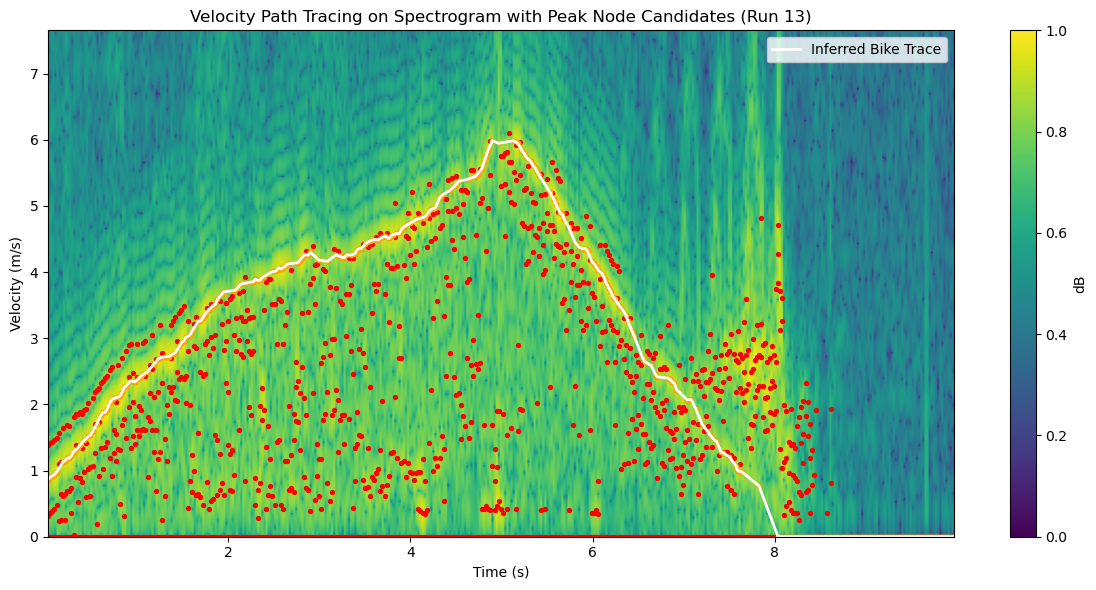

In [27]:
# Test out Velocity Path Tracking Code You can select any run number [1, 13]
run_number = 13
fs, data = extract_run(run_number)

velocity_yaxis=True
# get the spectrogram
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True, velocity=velocity_yaxis)
nodes = get_peaks(t, Sxx_norm)

# Find optimal paths
best_paths = find_best_paths(nodes, max_lookahead=20, beam_width=5)

# Visualize Path
path = min(best_paths, key=lambda p: p.cost)
print(path.cost)
plot_spectrogram_with_path(Sxx_norm, t, func, path, nodes, label='Inferred Bike Trace', title=f'Velocity Path Tracing on Spectrogram with Peak Node Candidates (Run {run_number})', velocity=velocity_yaxis)

# Extract time and frequency values from the path
times = np.array([t[peak.time_idx] for peak in path.peaks])
freqs = np.array([func[peak.frequency] for peak in path.peaks])

# Fit a polynomial
degree = 10
coeffs = np.polyfit(times, freqs, degree)

# Create a function to evaluate the fit
fit_fn = np.poly1d(coeffs)

## Velocity Tracking for the Second Target

1647.8625565122952


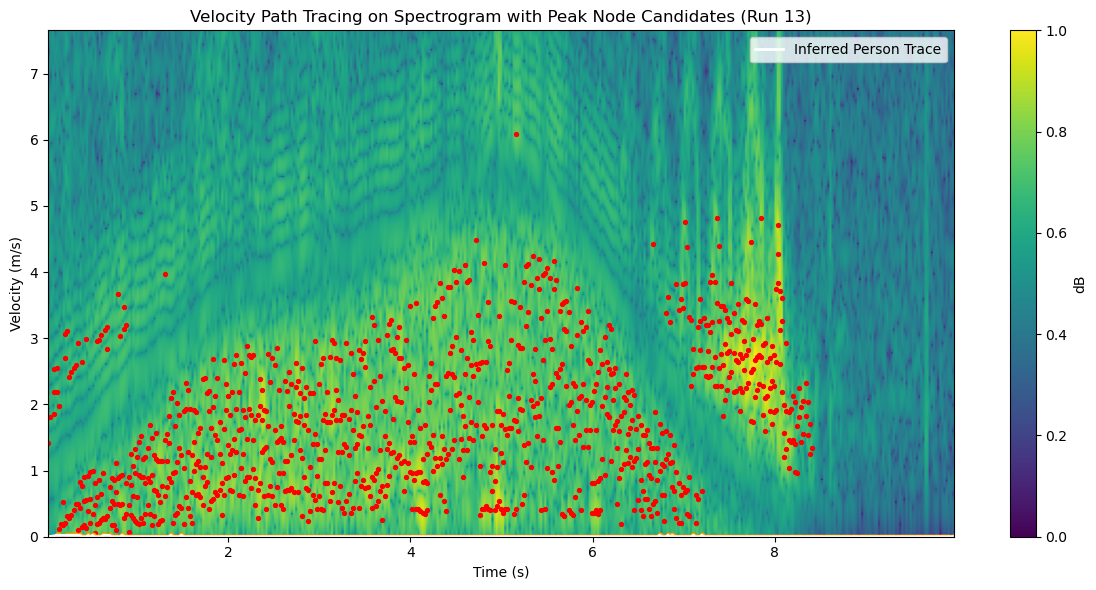

In [25]:
# Attempt at identifying the velocity track for the person relative to the bike
# Run this with the previous cell

# This function tries to surpress the peaks along the first objects track
# it takes in a slice and suppresses around the center of the track with a gaussian window
def suppress_peak_with_gaussian(slice, supress_idx, std_dev=10, suppression_strength=1.0):
    N = len(slice)
    n = np.arange(N)
    gaussian = np.exp(-0.5 * ((n - supress_idx) / std_dev) ** 2)
    mask = 1 - suppression_strength * gaussian  # Values in [1 - strength, 1]
    suppressed = slice * mask
    return suppressed

Sxx_path_removed = Sxx_norm.copy()
for time_idx in range(Sxx_path_removed.shape[1]):
    spectrum_slice = Sxx_path_removed[:, time_idx]
    freq_hz = fit_fn(t[time_idx])  # Make sure this is an int
    supress_idx = int(np.argmin(np.abs(func - freq_hz)))
    Sxx_path_removed[:, time_idx] = suppress_peak_with_gaussian(spectrum_slice, supress_idx, std_dev=30, suppression_strength=0.3)

# Rerun trace finding algorithm
nodes = [[] for _ in range(len(t))]

for t_idx in range(len(t)):
    spectrum_slice = Sxx_path_removed[:, t_idx]
    peaks, _ = scipy.signal.find_peaks(
        spectrum_slice,
        distance=5  # optional: to separate nearby peaks
    )
    if len(peaks) > 0:
        threshold_peaks = peaks[spectrum_slice[peaks] > 0.67]  # Filter peaks by magnitude threshold
        sorted_peaks = sorted(threshold_peaks, key=lambda x: spectrum_slice[x], reverse=True)
        top_peaks = sorted_peaks[:3]  # Take top 3
        for peak in top_peaks:
           nodes[t_idx].append(Peak(t_idx, peak, np.exp(spectrum_slice[peak])))
    nodes[t_idx].append(Peak(t_idx, 0, 1, penalty=True))

best_paths = find_best_paths(nodes, max_lookahead=20, beam_width=10)
# return the path with the minimum cost in best_paths

path = min(best_paths, key=lambda p: p.cost)
print(path.cost)
plot_spectrogram_with_path(Sxx_path_removed, t, func, path, nodes, label='Inferred Person Trace', title=f'Velocity Path Tracing on Spectrogram with Peak Node Candidates (Run {run_number})', velocity=velocity_yaxis)

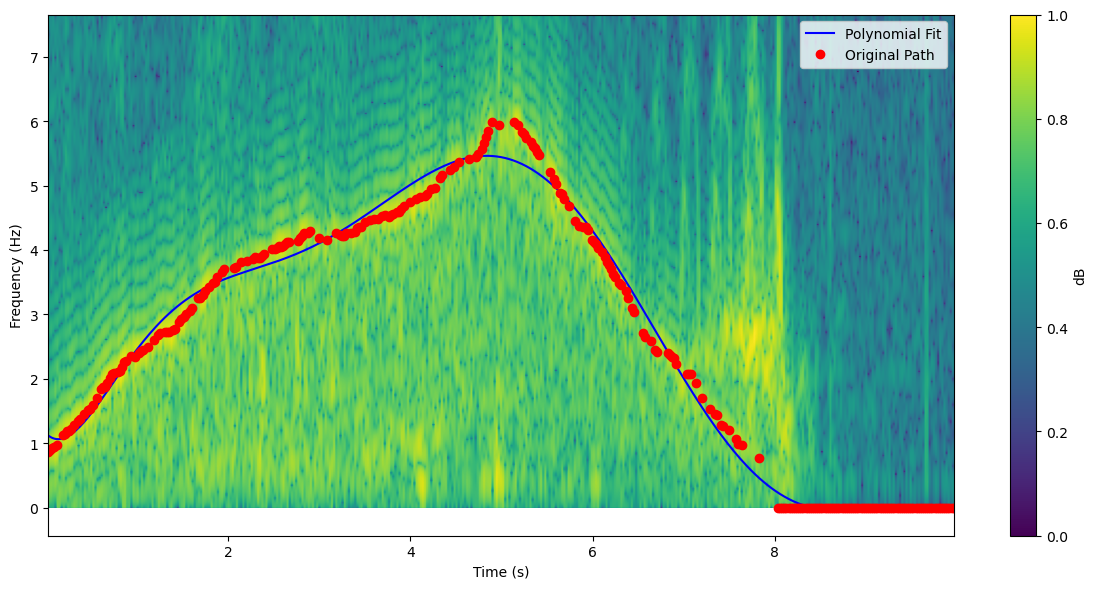

In [28]:
# We can optionally also fit the tracks to a polynomial and plot them n the spectrogram

# Extract time and frequency values from the path
times = np.array([t[peak.time_idx] for peak in path.peaks])
freqs = np.array([func[peak.frequency] for peak in path.peaks])

# Fit a polynomial (e.g., degree 2 or 3)
degree = 8
coeffs = np.polyfit(times, freqs, degree)

# Create a function to evaluate the fit
fit_fn = np.poly1d(coeffs)

# Optional: evaluate fit over original times
ts = t[t < times[-1]]
fitted_freqs = fit_fn(ts)

plt.figure(figsize=(12, 6))

# Plot the spectrogram
plt.imshow(Sxx_norm, aspect='auto', origin='lower',
            extent=[t[0], t[-1], func[0], func[-1]],
            cmap='viridis')

plt.plot(ts, fitted_freqs, 'b-', label='Polynomial Fit')
plt.plot(times, freqs, 'ro', label='Original Path')


plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='dB')
plt.legend()
plt.tight_layout()
plt.show()

# Label Data 
(Fast tracked making annotating training data using matplotlib.ginput using label_data.py)

Processing doppler_data_day2\Day_2-Test_Trial_5.wav


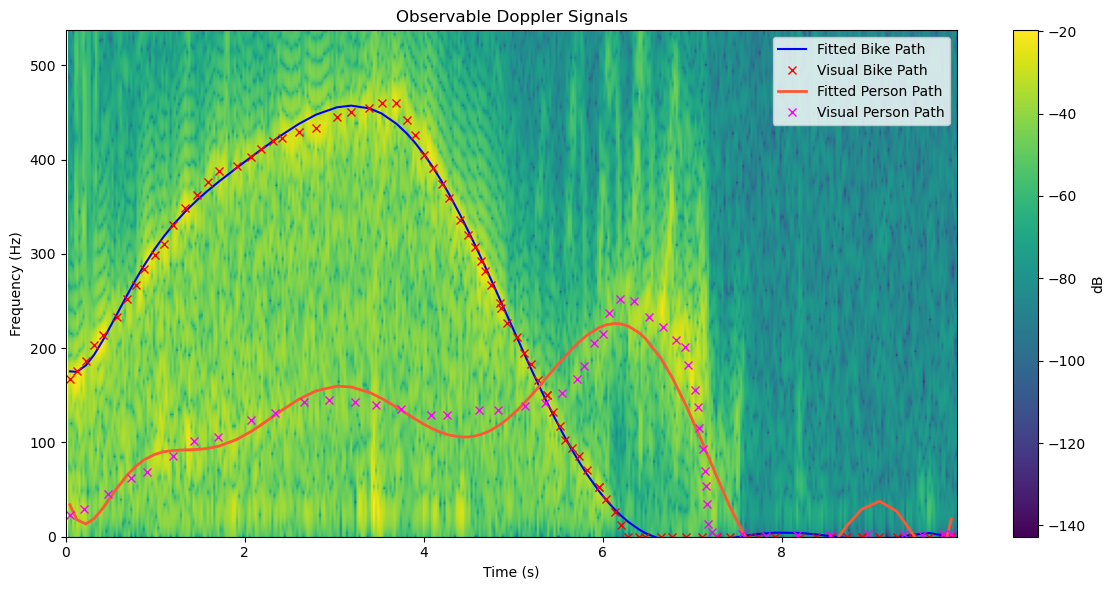

In [12]:
zipped_data_1 = [(0.03746818488446757, 92.9842862215909), (0.12295756630011634, 92.9842862215909), (0.23694340818764803, 99.18323863636365), (0.36517748031112096, 103.0575838955966), (0.46491509196271097, 111.5811434659091), (0.5575285884963306, 116.23035777698865), (0.6643903152658914, 122.42931019176137), (0.806872617625306, 127.0785245028409), (0.8994861141589252, 136.376953125), (0.9422308048667498, 141.80103648792615), (1.084713107226164, 151.09946511008525), (1.1417060281699298, 165.04710804332387), (1.3198089061191982, 176.67014382102275), (1.4480429782426711, 186.74344149502843), (1.5406564747762908, 199.91621537642044), (1.7258834678435295, 204.5654296875), (1.8968622306748266, 212.31412020596593), (2.0607168783881535, 227.03663219105113), (2.253067986573363, 234.01045365767044), (2.4596673249945145, 244.85862038352275), (2.6163978575898703, 254.93191805752843), (2.773128390185226, 265.7800847833807), (2.9441071530165237, 274.3036443536932), (3.1008376856118796, 278.95285866477275), (3.264692333325206, 279.7277277166193), (3.4427952112744746, 283.6020729758523), (3.592401628751859, 290.5758944424716), (3.770504506701127, 298.3245849609375), (3.9414832695324247, 305.2984064275568), (4.112462032363722, 309.9476207386364), (4.28344079519502, 318.4711803089489), (4.454419558026317, 323.12039462002843), (4.639646551093556, 332.4188232421875), (4.896114695340502, 344.0418590198864), (5.0385969976999165, 344.816728071733), (5.2380722210030966, 354.11515669389206), (5.401926868716424, 354.8900257457386), (5.587153861783662, 354.8900257457386), (5.765256739732931, 352.5654185901989), (5.914863157210315, 344.0418590198864), (6.021724883979877, 336.2931685014205), (6.142834840985379, 326.2198708274148), (6.263944797990881, 312.2722278941761), (6.34943417940653, 301.4240611683239), (6.413551215468266, 290.5758944424716), (6.4990405968839156, 278.95285866477275), (6.534661172473768, 268.87956099076706), (6.570281748063623, 261.90573952414775), (6.634398784125359, 253.38217995383525), (6.684267589951155, 244.08375133167613), (6.769756971366803, 230.91097745028412), (6.855246352782451, 217.73820356889206), (6.947859849316071, 201.46595348011363), (7.061845691203603, 186.74344149502843), (7.168707417973163, 170.47119140625), (7.2541967993888115, 154.9738103693182), (7.346810295922431, 139.47642933238637), (7.510664943635758, 121.65444113991478), (7.660271361113143, 94.5340243252841), (7.7742572030006745, 84.4607266512784), (7.881118929770235, 65.08900035511365), (7.966608311185885, 44.94240500710228), (8.12333884378124, 26.345547762784093), (8.265821146140654, 17.047119140625), (8.351310527556304, 0), (8.443924024089924, 0), (8.536537520623542, 0), (8.671895707864985, 0), (8.849998585814253, 0.0), (9.006729118409611, 0), (9.191956111476848, 0.0), (9.327314298718292, 0.0), (9.476920716195679, 0), (9.605154788319151, 0), (9.754761205796536, 0), (9.833126472094214, 0)]
zipped_data_12 = [(0.029898812571623745, 30.402215151863302), (0.09668739180259922, 38.758646103150056), (0.18351254480286738, 44.836050431358615), (0.23026455026455017, 53.19248138264538), (0.31708970326481856, 63.06826341598429), (0.4039148562650867, 72.18436990829713), (0.4907400092653549, 82.8198274826621), (0.610959451881111, 89.6569073518967), (0.7512154682661594, 99.53268938523561), (0.8513983371126228, 110.92782250062666), (0.938223490112891, 120.0439289929395), (1.0183697851900617, 128.40035994422627), (1.13191036988272, 147.392248469878), (1.2588086704215735, 164.8647859134776), (1.419101260575915, 173.22121686476436), (1.5326418452685733, 188.41472768528575), (1.6662190037305247, 196.01148309554645), (1.7931173042693782, 203.60823850580715), (1.899979031038939, 214.24369608017213), (2.0869870528856707, 230.1968824417196), (2.2072064955014263, 240.83234001608457), (2.3741779435788652, 256.0258508366059), (2.541149391656304, 263.6226062468666), (2.6546899763489624, 274.2580638212316), (2.7682305610416207, 281.8548192314923), (2.888450003657377, 297.0483300520137), (2.9886328725038402, 304.6450854622744), (3.142246604735084, 306.9241120853526), (3.26246604735084, 322.117622905874), (3.402722063735889, 325.91600061100434), (3.58973008558262, 336.5514581853693), (3.78341696535245, 351.7449690058907), (3.963746129276083, 357.0626977930732), (4.257615877892375, 368.45783090846425), (4.471339331431498, 378.3336129418031), (4.658347353278229, 383.6513417289856), (4.898786238509741, 392.00777268027235), (5.06575768658718, 399.60452809053305), (5.299517713895595, 403.4029057956634), (5.506562309511619, 408.7206345828459), (5.673533757589057, 409.48031012387196), (5.773716626435521, 404.92225687771554), (5.9674035062053505, 395.04647484437663), (6.094301806744204, 382.8916661879595), (6.221200107283057, 372.2562086135946), (6.328061834052617, 352.5046445469168), (6.401529271206691, 335.0321071033172), (6.501712140053154, 315.28054303663936), (6.628610440592007, 294.7693034289355), (6.708756735669178, 270.45968611610124), (6.802260746592545, 252.98714867250163), (6.882407041669715, 232.4759090647978), (6.969232194669983, 210.44531837504178), (7.049378489747154, 182.3373233570772), (7.162919074439813, 153.46965279808654), (7.229707653670788, 135.99711535448697), (7.316532806671056, 115.48587574678308), (7.3966791017482265, 98.77301384420954), (7.476825396825397, 75.22307207240141), (7.5836871235949594, 48.634428136488964), (7.69054885036452, 27.363512987759023), (7.750658571672398, 15.968379872367976), (7.764016287518592, 0), (7.844162582595763, 0), (7.897593445980544, 0), (8.024491746519397, 0), (8.184784336673738, 0), (8.42522322190525, 0), (8.632267817521274, 0), (8.89274327652208, 0), (9.073072440445713, 0), (9.266759320215542, 0), (9.453767342062275, 0), (9.694206227293787, 0), (9.841141101601933, 0)]
zipped_data_13 = [(0.03034406976649695, 69.73821466619319), (0.15145402677199926, 79.81151234019887), (0.31530867448532596, 96.08376242897728), (0.45066686172676973, 111.5811434659091), (0.6002732792041547, 123.97904829545456), (0.7071350059737156, 147.22511985085228), (0.8424931932151594, 161.1727627840909), (0.9920996106925448, 174.34553666548297), (1.1559542584058715, 188.29317959872162), (1.3696777119449932, 202.24082253196025), (1.554904705012232, 220.0628107244318), (1.704511122489617, 238.65966796875), (1.7971246190232366, 250.28270374644887), (1.9894757272084462, 261.1308704723011), (2.188950950511627, 275.0785134055398), (2.3456814831069828, 282.8272039240057), (2.4739155552304553, 282.0523348721591), (2.609273742471899, 285.92668013139206), (2.7588801599492845, 297.54971590909093), (2.9441071530165237, 298.3245849609375), (3.065217110022026, 293.675370649858), (3.271816448443177, 301.4240611683239), (3.4427952112744746, 313.04709694602275), (3.649394549695625, 321.57065651633525), (3.8987385788246005, 330.09421608664775), (4.0982138021277805, 340.9423828125), (4.29056491031299, 357.21463290127843), (4.440171327790376, 372.71201393821025), (4.554157169677907, 379.68583540482956), (4.653894781329497, 382.0104425603693), (4.7393841627451465, 393.6334783380682), (4.817749429042824, 412.2303355823864), (4.888990580222531, 423.0785023082387), (4.97447996163818, 423.0785023082387), (5.081341688407741, 421.5287642045455), (5.159706954705419, 411.4554665305398), (5.252320451239038, 399.83243075284093), (5.352058062890628, 386.6596568714489), (5.430423329188306, 377.3612282492898), (5.56578151642975, 362.63871626420456), (5.644146782727428, 347.14133522727275), (5.715387933907135, 334.7434303977273), (5.793753200204813, 326.9947398792614), (5.886366696738433, 309.1727516867898), (5.964731963036111, 298.3245849609375), (6.043097229333789, 287.47641823508525), (6.085841920041613, 278.1779896129261), (6.142834840985379, 271.2041681463068), (6.206951877047115, 260.35600142045456), (6.242572452636969, 251.05757279829544), (6.320937718934647, 242.53401322798294), (6.392178870114354, 229.36123934659093), (6.491916481765944, 216.96333451704544), (6.563157632945652, 206.8900368430398), (6.620150553889417, 196.0418701171875), (6.727012280658979, 185.9685724431818), (6.805377546956656, 174.34553666548297), (6.869494583018392, 168.14658425071025), (6.926487503962159, 154.9738103693182), (7.011976885377807, 143.3507745916193), (7.111714497029398, 133.27747691761365), (7.204327993563016, 116.23035777698865), (7.318313835450548, 108.48166725852275), (7.467920252927934, 91.43454811789775), (7.546285519225611, 82.13611949573865), (7.638899015759231, 70.51308371803978), (7.767133087882705, 60.43978604403409), (7.9167395053600895, 49.59161931818183), (8.044973577483562, 32.54450017755683), (8.109090613545298, 20.921464399857953), (8.173207649607036, 9.298428622159093), (8.244448800786742, 4.649214311079547), (8.32281406708442, 0), (8.472420484561805, 0), (8.629151017157161, 0.0), (8.736012743926723, 0), (8.835750355578313, 0), (9.127839075415112, 0), (9.334438413836263, 0), (9.562410097611327, 0), (9.740512975560595, 0), (9.854498817448127, 0), (9.932864083745804, 0)]
zipped_bike_5 = [(0.04459230000243841, 167.37171519886365), (0.12295756630011634, 175.89527476917615), (0.22269517795170657, 186.74344149502843), (0.31530867448532596, 203.0156915838068), (0.41504628613691597, 213.86385830965912), (0.5717768187322718, 233.23558460582387), (0.6857626606198035, 251.83244185014206), (0.7783761571534231, 266.5549538352273), (0.8709896536870423, 283.6020729758523), (0.9920996106925448, 298.3245849609375), (1.0918372223441348, 309.9476207386364), (1.1915748339957248, 330.8690851384943), (1.3340571363551395, 348.69107333096593), (1.4694153235965832, 361.863847212358), (1.583401165484115, 376.5863591974432), (1.7116352376075878, 387.4345259232955), (1.9111104609107683, 393.6334783380682), (2.067840993506124, 402.9319069602273), (2.1818268353936556, 411.4554665305398), (2.3171850226350994, 419.2041570490057), (2.409798519168719, 423.0785023082387), (2.6021496273539286, 429.2774547230114), (2.7945007355391382, 433.92666903409093), (3.029596534432172, 444.77483575994324), (3.186327067027528, 450.19891912286937), (3.392926405448679, 454.8481334339489), (3.528284592690123, 459.4973477450284), (3.692139240403449, 459.4973477450284), (3.813249197408952, 441.67535955255687), (3.8987385788246005, 426.177978515625), (4.005600305594162, 405.25651411576706), (4.0982138021277805, 391.30887118252843), (4.197951413779371, 374.26175204190343), (4.276316680077049, 359.5392400568182), (4.404550752200522, 335.5182994495739), (4.4971642487341414, 320.02091841264206), (4.575529515031819, 307.6230135830966), (4.639646551093556, 292.1256325461648), (4.682391241801381, 282.0523348721591), (4.753632392981087, 266.5549538352273), (4.853370004632677, 247.95809659090912), (4.860494119750649, 242.53401322798294), (4.931735270930356, 227.03663219105113), (5.0385969976999165, 212.31412020596593), (5.124086379115565, 195.26700106534093), (5.195327530295272, 182.86909623579544), (5.27369279659295, 166.59684614701706), (5.37343040824454, 150.32459605823865), (5.37343040824454, 150.32459605823865), (5.444671559424248, 132.50260786576706), (5.523036825721926, 117.00522682883525), (5.572905631547721, 102.28271484375), (5.651270897845399, 94.5340243252841), (5.7367602792610475, 85.235595703125), (5.822249660676697, 70.51308371803978), (5.9576078479181405, 52.69109552556819), (5.9576078479181405, 52.69109552556819), (6.035973114215818, 40.293190696022734), (6.135710725867408, 26.345547762784093), (6.199827761929145, 12.397904829545453), (6.285317143344793, 0), (6.406427100350296, 0.0), (6.4776682515300035, 0), (6.6486470143613, 0.0), (6.776881086484773, 0.0), (6.9336116190801285, 0), (7.104590381911427, 0), (7.2755691447427235, 0), (7.418051447102139, 0), (7.62465078552329, 0), (7.738636627410822, 0), (7.923863620478061, 0), (8.20882822519689, 0), (8.379806988028186, 0), (8.550785750859484, 0), (8.728888628808752, 0), (8.89274327652208, 0), (8.89274327652208, 0), (9.09221849982526, 0), (9.284569608010468, 0), (9.455548370841766, 0), (9.647899479026975, 0), (9.811754126740302, 0), (9.89724350815595, 0)]
zipped_person_5 = [(0.04459230000243841, 23.246071555397734), (0.20132283259779427, 29.445023970170453), (0.4720392070806818, 44.94240500710228), (0.7285073513276281, 61.98952414772728), (0.906610229276896, 68.9633456143466), (1.1915748339957248, 85.235595703125), (1.4337947480067295, 101.5078457919034), (1.704511122489617, 105.38219105113637), (2.067840993506124, 123.97904829545456), (2.331433252871041, 130.95286976207387), (2.666266663415665, 143.3507745916193), (2.9441071530165237, 144.9005126953125), (3.2361958728533233, 143.3507745916193), (3.4641675566283867, 139.47642933238637), (3.749132161347215, 135.6020840731534), (4.08396557189184, 128.6282626065341), (4.262068449841108, 129.4031316583807), (4.6182742057396435, 134.05234596946025), (4.831997659278765, 134.05234596946025), (5.131210494233536, 138.70156028053978), (5.352058062890628, 141.80103648792615), (5.544409171075838, 152.6492032137784), (5.708263818789165, 167.37171519886365), (5.786629085086843, 181.3193581321023), (5.907739042092345, 205.34029873934662), (6.007476653743935, 214.6387273615057), (6.064469574687701, 237.1099298650568), (6.192703646811174, 252.60731090198863), (6.34943417940653, 250.28270374644887), (6.513288827119856, 233.23558460582387), (6.670019359715212, 222.38741787997162), (6.8196257771925985, 208.43977494673294), (6.919363388844188, 201.46595348011363), (6.947859849316071, 182.09422718394887), (7.033349230731719, 155.74867942116478), (7.061845691203603, 137.9266912286932), (7.0760939214395435, 115.45548872514206), (7.125962727265339, 92.9842862215909), (7.14021095750128, 69.73821466619319), (7.154459187737222, 54.240833629261374), (7.168707417973163, 34.86910733309659), (7.175831533091134, 13.94764293323864), (7.22570033891693, 5.42408336292614), (7.268445029624754, 0.7748690518465935), (7.553409634343582, 3.0994762073863598), (7.82412600882647, 0.7748690518465935), (8.173207649607036, 2.3246071555397805), (8.543661635741513, 1.549738103693187), (8.963984427701785, 3.0994762073863598), (9.370058989426116, 3.0994762073863598), (9.569534212729298, 2.3246071555397805), (9.79750589650436, 3.0994762073863598), (9.89724350815595, 3.0994762073863598)]

# Visualize the annotated functions
def get_training_fit(run, zipped_data):
  # Labeled data for trials
  times, freqs = zip(*zipped_data)

  ground_truth_path = np.poly1d(np.polyfit(times, freqs, 10))

  return ground_truth_path

fs, data = extract_run(5)
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=False)

ground_truth_path_bike = get_training_fit(1, zipped_bike_5)
ground_truth_path_person = get_training_fit(1, zipped_person_5)

times, freqs = zip(*zipped_bike_5)
times_p, freqs_p = zip(*zipped_person_5)

plt.figure(figsize=(12, 6))

# Plot the spectrogram
plt.imshow(Sxx_norm, aspect='auto', origin='lower',
            extent=[t[0], t[-1], func[0], func[-1]],
            cmap='viridis')

plt.plot(times, ground_truth_path_bike(times), 'b-', label='Fitted Bike Path')
plt.plot(times, freqs, 'rx', label='Visual Bike Path')
# Fitted Person Path – bright orange-red (distinct from spectrogram)
plt.plot(times, ground_truth_path_person(times), color='#FF5733', linestyle='-', linewidth=2, label='Fitted Person Path')

# Visual Person Path – magenta (colorblind-safe and vivid)
plt.plot(times_p, freqs_p, color='magenta', marker='x', linestyle='', label='Visual Person Path')

plt.title("Observable Doppler Signals")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.colorbar(label='dB')
plt.legend()
plt.tight_layout()
plt.show()

# Attempt Training

This portion was done with the help of Claude AI to refactor code to make it more efficient.
The underlying cost functions were developed by myself based on my intuition and reasoning on how to maximize results compared to computational costs, but refactoring (specifically making a compact path class and reintegrating it into the skeletons of cost_function, get_peaks, and plotting functions, was done with the help of AI).

In [13]:
from dataclasses import dataclass
from typing import Optional, List

@dataclass
class Peak:
    time_idx: int
    frequency: int
    magnitude: float
    penalty: bool = False

@dataclass
class CompactPath:
    last_peak: Peak
    cost: float
    parent: Optional['CompactPath']
    last_slope: float = 0.0  # Use for acceleration penalty
    length: int = 1          # Optional, useful for tracking depth

    def extend(self, new_peak: Peak, added_cost: float) -> 'CompactPath':
        dt = new_peak.time_idx - self.last_peak.time_idx
        df = new_peak.frequency - self.last_peak.frequency
        slope = df / dt if dt != 0 else 0.0

        return CompactPath(
            last_peak=new_peak,
            cost=self.cost + added_cost,
            parent=self,
            last_slope=slope,
            length=self.length + 1
        )

    def reconstruct(self) -> List[Peak]:
        path = []
        node = self
        while node:
            path.append(node.last_peak)
            node = node.parent
        return path[::-1]

In [14]:
def cost_function(
    path: CompactPath,
    candidate: Peak,
    lookahead_steps: int,
    c_accel: float = 0.5,
    c_mag: float = 1.0,
    skip_power: float = 1.1,
    penalty_cost: float = 10.0,
) -> float:
    if candidate.penalty:
        return penalty_cost * (lookahead_steps ** skip_power)

    dt = candidate.time_idx - path.last_peak.time_idx
    if dt <= 0:
        return float('inf')

    df = candidate.frequency - path.last_peak.frequency
    slope = df / dt
    accel_penalty = (slope - path.last_slope) ** 2

    # jump = abs(slope)

    mag_penalty = 1 - candidate.magnitude

    base_cost = c_accel * accel_penalty + c_mag * mag_penalty # + c_jump * jump_penalty
    return base_cost * (lookahead_steps ** skip_power)


In [15]:
# Simplified loss function with fewer tunables
def loss(params):
    c_accel, c_mag, c_jump, penalty_cost = params

    best_paths = find_best_paths(
        nodes, max_lookahead=40, beam_width=10,
        cost_args=dict(
            c_accel=c_accel,
            c_mag=c_mag,
            penalty_cost=penalty_cost,
            skip_power=1.1,
        )
    )

    path = best_paths[0]

    path_reconstructed = path.reconstruct()

    times = np.array([t[peak.time_idx] for peak in path_reconstructed])
    freqs = np.array([func[peak.frequency] for peak in path_reconstructed])

    # Fit and predict
    coeffs = np.polyfit(times, freqs, 5)
    predicted = np.poly1d(coeffs)(t[::3])

    return np.mean((predicted - ground_truth_path)**2)

In [16]:
def get_peaks(t, Sxx_norm, max_peaks=3, threshold=0.65):
    # Find and filter peaks
    nodes = [[] for _ in range(len(t))]
    for t_idx in range(len(t)):
        spectrum_slice = Sxx_norm[:, t_idx]
        peaks, _ = scipy.signal.find_peaks(
            spectrum_slice,
            distance=5  # optional: to separate nearby peaks
        )
        if len(peaks) > 0:
            threshold_peaks = peaks[spectrum_slice[peaks] > threshold]  # Filter peaks by magnitude threshold
            sorted_peaks = sorted(threshold_peaks, key=lambda x: spectrum_slice[x], reverse=True)
            top_peaks = sorted_peaks[:max_peaks]  # Take top 3
            for peak in top_peaks:
                nodes[t_idx].append(Peak(t_idx, peak, np.exp(spectrum_slice[peak])))
        nodes[t_idx].append(Peak(t_idx, 0, 1, penalty=True))
    return nodes

def find_best_paths(nodes, max_lookahead=3, beam_width=5, cost_args=None):
    if cost_args is None:
        cost_args = {}

    all_paths = []

    initial_peaks = nodes[0]
    beam = [
        CompactPath(
            last_peak=p,
            cost=0.0,
            parent=None,
            last_slope=0.0,
            length=1
        )
        for p in initial_peaks
    ]

    while beam:
        new_beam = []

        for path in beam:
            for lookahead in range(1, max_lookahead + 1):
                next_idx = path.last_peak.time_idx + lookahead
                if next_idx >= len(nodes):
                    continue

                for candidate in nodes[next_idx]:
                    cost = cost_function(path, candidate, lookahead, **cost_args)
                    new_path = path.extend(candidate, cost)
                    new_beam.append(new_path)

        if not new_beam:
            break

        # Beam pruning: retain top N paths by lowest cost
        beam = heapq.nsmallest(beam_width, new_beam, key=lambda p: p.cost)

    all_paths.extend(beam)

    return all_paths


import matplotlib.pyplot as plt

def plot_spectrogram_with_path(Sxx, t, func, path, nodes, label_func=None, title="Spectrogram with Tracked Path"):
    plt.figure(figsize=(12, 6))

    # Plot the spectrogram
    plt.imshow(Sxx, aspect='auto', origin='lower',
               extent=[t[0], t[-1], func[0], func[-1]],
               cmap='viridis')

    # Use .reconstruct() to get full peak sequence
    path_peaks = path.reconstruct()

    # Extract time and frequency values from the path
    times = [t[p.time_idx] for p in path_peaks]
    freqs = [func[p.frequency] for p in path_peaks]

    # Flatten all nodes
    all_nodes = [peak for sublist in nodes for peak in sublist]
    all_times = [t[p.time_idx] for p in all_nodes]
    all_freqs = [func[p.frequency] for p in all_nodes]

    # Plot the path
    if label_func:
        plt.plot(times, label_func(times), 'b-', label='Labeled Fit')
    plt.plot(times, freqs, 'w-', linewidth=2, label='Tracked Path')
    plt.scatter(all_times, all_freqs, c='red', s=8, label='Peak Candidates')
    # plt.scatter(times, freqs, c='orange', s=10, label='Path Points')

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(bottom=0)
    plt.colorbar(label='dB')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
ground_truth_func = get_training_fit(1, zipped_data_1)

In [21]:
from scipy.optimize import differential_evolution

# Get training fit
ground_truth_func = get_training_fit(1, zipped_data_1)
# Get training data
fs, data = extract_run(1)

func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)
nodes = get_peaks(t, Sxx_norm)

ground_truth_path = ground_truth_func(t[::3])

# Run training
bounds=[(-3, 3), (-3, 3), (-3, 3), (0, 50)]

# First run
results = differential_evolution(loss, bounds, maxiter=15, disp=True)
x0 = results.x  # Best params so far

Processing doppler_data_day2\Day_2-Test_Trial_1.wav
differential_evolution step 1: f(x)= 336.545
differential_evolution step 2: f(x)= 336.545
differential_evolution step 3: f(x)= 336.545
differential_evolution step 4: f(x)= 336.545
differential_evolution step 5: f(x)= 331.239
differential_evolution step 6: f(x)= 331.239
differential_evolution step 7: f(x)= 331.239
differential_evolution step 8: f(x)= 331.239
differential_evolution step 9: f(x)= 331.239
differential_evolution step 10: f(x)= 254.136
differential_evolution step 11: f(x)= 254.136
differential_evolution step 12: f(x)= 254.136
differential_evolution step 13: f(x)= 254.136
differential_evolution step 14: f(x)= 254.136
differential_evolution step 15: f(x)= 252.494


In [34]:
x0

array([ 2.34718804, -0.89564016, -1.3196644 , 15.46472552])

Processing doppler_data_day2\Day_2-Test_Trial_1.wav
Best path cost: 1333.4389554486488


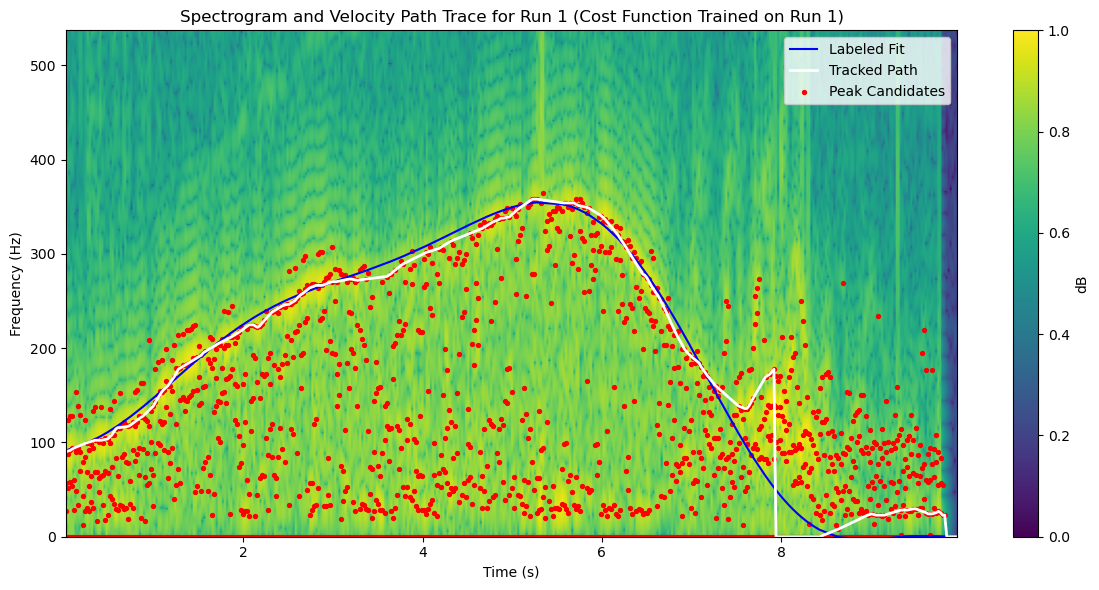

In [18]:
fs, data = extract_run(1)

func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)
nodes = get_peaks(t, Sxx_norm)

label_func = get_training_fit(1, zipped_data_1)

c_accel, c_mag, c_jump, penalty_cost = [*[2.34718804, -0.89564016, -1.3196644 , 15.46472552]]

best_paths = find_best_paths(
    nodes, max_lookahead=40, beam_width=10,
    cost_args=dict(
        c_accel=c_accel,
        c_mag=c_mag,
        penalty_cost=penalty_cost,
        skip_power=1.1,
    )
)
# jump is useless

# Get the best path (lowest cost)
path = min(best_paths, key=lambda p: p.cost)
print(f"Best path cost: {path.cost}")

# Plot the spectrogram and tracked path
plot_spectrogram_with_path(Sxx_norm, t, func, path, nodes, label_func=label_func, title='Spectrogram and Velocity Path Trace for Run 1 (Cost Function Trained on Run 1)')

# Get peaks for polynomial fit
path_peaks = path.reconstruct()
times = np.array([t[peak.time_idx] for peak in path_peaks])
freqs = np.array([func[peak.frequency] for peak in path_peaks])

# Fit a polynomial (e.g., degree 3–5 is usually enough)
degree = 8
coeffs = np.polyfit(times, freqs, degree)
fit_fn = np.poly1d(coeffs)

Processing doppler_data_day2\Day_2-Test_Trial_6.wav
Best path cost: 5202.443510892512


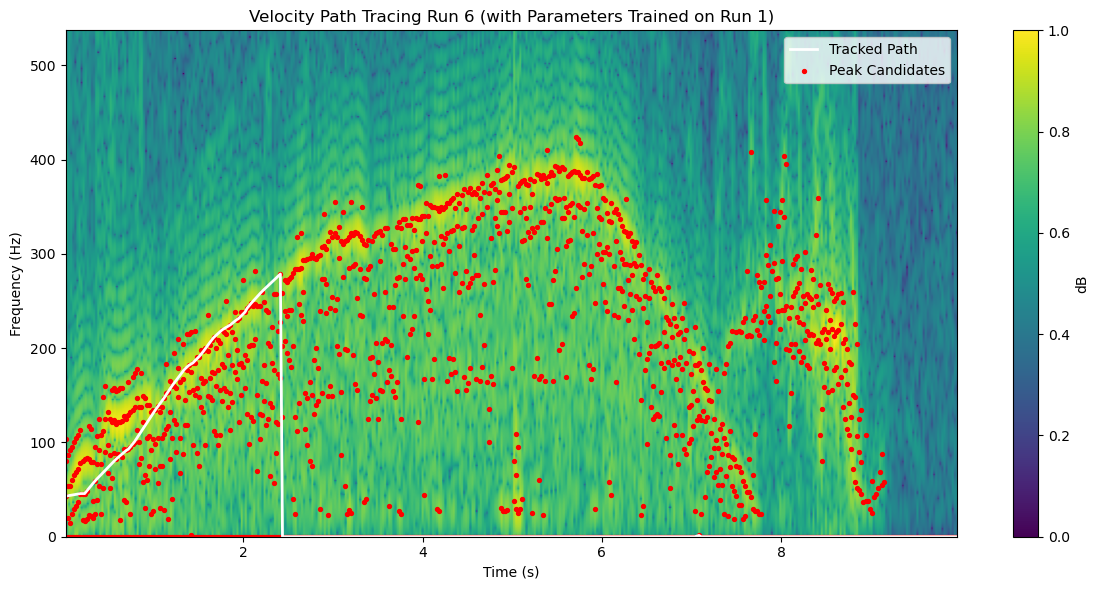

In [20]:
run_number = 6

# Make sure to change zipped data and the run number if you want to visualize any other runs
fs, data = extract_run(run_number)

func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)
nodes = get_peaks(t, Sxx_norm)

c_accel, c_mag, c_jump, penalty_cost = [*[2.34718804, -0.89564016, -1.3196644 , 15.46472552]]

best_paths = find_best_paths(
    nodes, max_lookahead=40, beam_width=10,
    cost_args=dict(
        c_accel=c_accel,
        c_mag=c_mag,
        penalty_cost=penalty_cost,
        skip_power=1.1,
    )
)
# jump is useless

# Get the best path (lowest cost)
path = min(best_paths, key=lambda p: p.cost)
print(f"Best path cost: {path.cost}")

# Plot the spectrogram and tracked path
plot_spectrogram_with_path(Sxx_norm, t, func, path, nodes, title=f'Velocity Path Tracing Run {run_number} (with Parameters Trained on Run 1)')

# Get peaks for polynomial fit
path_peaks = path.reconstruct()
times = np.array([t[peak.time_idx] for peak in path_peaks])
freqs = np.array([func[peak.frequency] for peak in path_peaks])

# Fit a polynomial (e.g., degree 3–5 is usually enough)
degree = 8
coeffs = np.polyfit(times, freqs, degree)
fit_fn = np.poly1d(coeffs)